# Loading the Data Set

In [ ]:
import numpy

test_size = 550000

dtrain = numpy.loadtxt('/content/drive/My Drive/Higgs Boson classifier/training.csv', delimiter=',', skiprows=1,
                    converters={32: lambda x: int(x == 's'.encode('utf-8'))})

y_train = dtrain[:, -1]
X_train = dtrain[:, 1:31]
weight_train = dtrain[:, 31] * float(test_size)/len(y_train)

dtest = numpy.loadtxt('/content/drive/My Drive/Higgs Boson classifier/test.csv', delimiter=',', skiprows=1 )


X_test   = dtest[:,1:31]
EventID = dtest[:,0]

# Feature Selection Using Principal Component Analysis

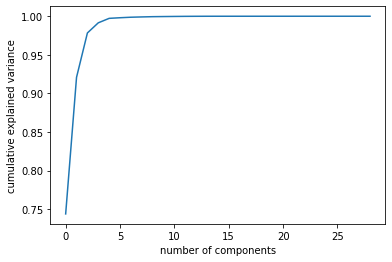

In [ ]:
from matplotlib import pyplot
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)
pyplot.plot(numpy.cumsum(pca.explained_variance_ratio_))
pyplot.xlabel('number of components')
pyplot.ylabel('cumulative explained variance');

In [ ]:
pca = PCA(n_components=5, svd_solver='full').fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# Feature Selection Using Recursive Feature Eliminator

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

rfc = RandomForestClassifier()
rfe = RFECV(rfc)
rfe.fit(X_train, y_train)
rfe.get_support()

rfe.transform(X_train)
rfe.transform(X_test)

dump(X_train, '/content/drive/My Drive/Higgs Boson classifier/X_train_wo_derived_reduced.joblib')
dump(X_test, '/content/drive/My Drive/Higgs Boson classifier/X_test_wo_derived_reduced.joblib')

['/content/drive/My Drive/Higgs Boson classifier/X_test_wo_derived_reduced.joblib']

# GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

param_grid = {
    'n_estimators': [64, 96, 128],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 50]}

X_train = load('/content/drive/My Drive/Higgs Boson classifier/X_train_wo_derived_reduced.joblib')
rfc = RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3, verbose = 1)
grid_search.fit(X_train, y_train, weights_train)
print(grid_search.best_params_)
rfc = grid_search.best_estimator_

# Classification Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train, weights_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Saving the Model and Making Predictions

In [ ]:
from joblib import dump
dump(rfc, '/content/drive/My Drive/Higgs Boson classifier/grid_searched_best_params.joblib')

In [ ]:
from joblib import load
rfc = load('/content/drive/My Drive/Higgs Boson classifier/randomforestclsf.joblib')

In [ ]:
X_test = load('/content/drive/My Drive/Higgs Boson classifier/X_test_wo_derived_reduced.joblib')

In [ ]:
y_pred = rfc.predict(X_test)

# Preparing the Data for Scoring


In [ ]:
threshold_ratio = 0.15
outfile = '/content/drive/My Drive/Higgs Boson classifier/submission_random_forest.csv'

res  = [ ( int(EventID[i]), y_pred[i] ) for i in range(len(y_pred)) ]

rorder = {}
for k, v in sorted( res, key = lambda x:-x[1] ):
    rorder[ k ] = len(rorder) + 1


ntop = int( threshold_ratio * len(rorder ) )
fo = open(outfile, 'w')
nhit = 0
ntot = 0
fo.write('EventId,RankOrder,Class\n')
for k, v in res:
    if rorder[k] <= ntop:
        lb = 's'
        nhit += 1
    else:
        lb = 'b'
    fo.write('%s,%d,%s\n' % ( k,  len(rorder)+1-rorder[k], lb ) )
    ntot += 1
fo.close()